Training on dummy data...
Epoch 1 | G Loss: 0.6735 | D Loss: 1.4017
Epoch 2 | G Loss: 0.6271 | D Loss: 1.3992
Epoch 3 | G Loss: 0.6878 | D Loss: 1.3320
Epoch 4 | G Loss: 0.6927 | D Loss: 1.2865
Epoch 5 | G Loss: 0.6996 | D Loss: 1.2412
Generating image...


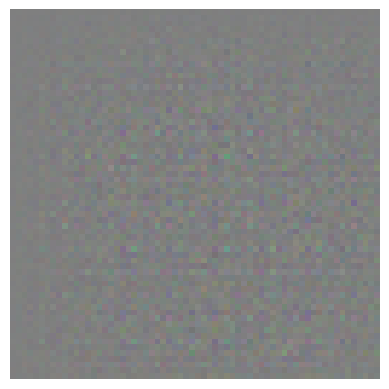

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np

IMG_SHAPE, TEXT_DIM, NOISE_DIM = 64, 4800, 100
BATCH_SIZE = 64

def make_gen():

    i_noise, i_text = layers.Input((NOISE_DIM,)), layers.Input((TEXT_DIM,))
    x = layers.Reshape((4,4,256))(layers.LeakyReLU()(layers.BatchNormalization()(layers.Dense(4*4*256, use_bias=False)(layers.concatenate([i_noise, i_text])))))

    for f in [128, 64, 32]: # Upsampling blocks
        x = layers.LeakyReLU()(layers.BatchNormalization()(layers.Conv2DTranspose(f, 5, strides=2, padding='same', use_bias=False)(x)))

    out = layers.Conv2DTranspose(3, 5, strides=2, padding='same', activation='tanh')(x)
    return models.Model([i_noise, i_text], out)

def make_disc():

    i_img, i_text = layers.Input((IMG_SHAPE, IMG_SHAPE, 3)), layers.Input((TEXT_DIM,))
    x = i_img
    for f in [64, 128]: # Downsampling blocks
        x = layers.Dropout(0.3)(layers.LeakyReLU()(layers.Conv2D(f, 5, strides=2, padding='same')(x)))


    merged = layers.concatenate([layers.Flatten()(x), layers.Dense(128)(i_text)])
    return models.Model([i_img, i_text], layers.Dense(1)(merged))

gen, disc = make_gen(), make_disc()
g_opt, d_opt = optimizers.Adam(2e-4, 0.5), optimizers.Adam(2e-4, 0.5)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


@tf.function
def train_step(real_img, txt_emb):
    current_batch_size = tf.shape(txt_emb)[0]
    noise = tf.random.normal([current_batch_size, NOISE_DIM])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_img = gen([noise, txt_emb], training=True)

        real_pred = disc([real_img, txt_emb], training=True)
        fake_pred = disc([fake_img, txt_emb], training=True)

        g_loss = bce(tf.ones_like(fake_pred), fake_pred)
        d_loss = bce(tf.ones_like(real_pred), real_pred) + bce(tf.zeros_like(fake_pred), fake_pred)

    g_opt.apply_gradients(zip(g_tape.gradient(g_loss, gen.trainable_variables), gen.trainable_variables))
    d_opt.apply_gradients(zip(d_tape.gradient(d_loss, disc.trainable_variables), disc.trainable_variables))
    return g_loss, d_loss


print("Training on dummy data...")

dummy_data = tf.data.Dataset.from_tensor_slices((
    tf.random.uniform([100, IMG_SHAPE, IMG_SHAPE, 3], -1, 1),
    tf.random.normal([100, TEXT_DIM])
)).batch(BATCH_SIZE)

for epoch in range(5):
    for img, txt in dummy_data:
        gl, dl = train_step(img, txt)
    print(f"Epoch {epoch+1} | G Loss: {gl:.4f} | D Loss: {dl:.4f}")


print("Generating image...")
pred = gen([tf.random.normal([1, NOISE_DIM]), tf.random.normal([1, TEXT_DIM])])
plt.imshow((pred[0].numpy() + 1) / 2.0) # Denormalize to [0,1]
plt.axis('off')
plt.show()